In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import tensorweave as tw
import joblib

# Set device
device = "cpu"
dtype = torch.float32

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

In [3]:
# High resolution dataset
full_dataset_hr = np.load("../Datasets/synthetic_highres.npy")
# Coordinates (m)
xyz_hr = full_dataset_hr[:, (0, 1, 2)]
# Gravitational acceleration (mGal)
g_hr = full_dataset_hr[:, (3, 4, 5)]
# Gradiometry (Eotvos)
ftg_hr = full_dataset_hr[:, 6:]

# Interpolation grid from the high res dataset
xvec = xyz_hr[:, 0] # Extract x-coordinates
yvec = xyz_hr[:, 1] # Extract y-coordinates
zvec = xyz_hr[:, 2] # Extract z-coordinates
grid = np.c_[xvec, yvec, zvec] # shape: (N, 3)
actv = np.ones_like(xvec).astype(bool) # Active grid points (all points are active in this case)
shape = (65, 65) # Reshape for plotting
x_mesh = xvec.reshape(shape)[:, 0] # Reshape x-coordinates for plotting
y_mesh = yvec.reshape(shape)[0] # Reshape y-coordinates for plotting

In [4]:
# Low resolution dataset
full_dataset = np.load("../Datasets/synthetic_lowres_200.npy")
# Coordinates
xyz = full_dataset[:, (0, 1, 2)]
# Gravitational acceleration
g = full_dataset[:, (3, 4, 5)]
# Gradiometry
ftg = full_dataset[:, 6:]
# Add some noise to the data
ftg = tw.add_ftg_noise_by_snr(ftg, snr_db=[20, 18, 18, 15, 17, 19])
ftg[:, -1] = -(ftg[:, 0] + ftg[:, 3])  # Enforce tracelessness

# Preload active grid points (for Laplacian loss)
actv_points = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)

In [5]:
# Load the model ensemble
ens = torch.load("../Models/synthetic_ensemble.pkl")

In [6]:
# Let's check he ensemble!
print(f"Number of members in ensemble: {ens.n_members}")

Number of members in ensemble: 25


In [7]:
# Evaluate using the predict method N.B: predict() outputs a numpy array, for a numpy array input.
predicted_hessian, predicted_std, _ = ens.predict(actv_points, output="hessian", return_std=True,  chunk_size=2048)
# Create an array to hold gradient components over the full grid
enf_grid, enf_std = np.full((xvec.shape[0], 6), np.nan), np.full((xvec.shape[0], 6), np.nan)
# Reshape the predicted hessian and store it in the hess_components array
enf_grid[actv] = predicted_hessian.reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)] # xx, xy, xz, yy, yz, zz
enf_std[actv] = predicted_std.reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)] # xx, xy, xz, yy, yz, zz

Evaluating: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


In [8]:
# For comparison, let's get the predictions for individual models
nf_grid = []
for m in ens.members:
    nf_grid.append(m.predict(actv_points, output="hessian", chunk_size=1024).reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)])

In [9]:
# Compute the RBF and CT
from scipy.interpolate import RBFInterpolator as RBF
from scipy.interpolate import CloughTocher2DInterpolator as CT

# Initialise the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=250, smoothing=1e2)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_grid[actv] = rbf_func(grid[actv, :-1])

# Initialise the CT
ct_func = CT(xyz[:, :-1], ftg)
ct_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
ct_grid[actv] = ct_func(grid[actv, :-1])

In [10]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import structural_similarity as ssim

# RBF
rbf_r2 = np.array([r2_score(ftg_hr[:, k], rbf_grid[:, k]) for k in range(6)])
norm_rbf_r2 = np.linalg.norm(rbf_r2)/ np.sqrt(6)  # Normalized R2 score
rbf_mse = np.array([mean_squared_error(ftg_hr[:, k], rbf_grid[:, k]) for k in range(6)])
norm_rbf_mse = np.linalg.norm(rbf_mse)/ np.sqrt(6)  # Normalized MSE

# Tensorweave
enf_r2 = np.array([r2_score(ftg_hr[:, k], enf_grid[:, k]) for k in range(6)])
norm_enf_r2 = np.linalg.norm(enf_r2)/ np.sqrt(6)  # Normalized R2 score
enf_mse = np.array([mean_squared_error(ftg_hr[:, k], enf_grid[:, k]) for k in range(6)])
norm_enf_mse = np.linalg.norm(enf_mse)/ np.sqrt(6)  # Normalized MSE

# Compute the R2 for every individual prediction
nf_r2 = []
nf_mse = []
for i in range (len(nf_grid)):
    nf_r2.append(np.array([r2_score(ftg_hr[:, k], nf_grid[i][:, k]) for k in range(6)]))
    nf_mse.append(np.array([mean_squared_error(ftg_hr[:, k], nf_grid[i][:, k]) for k in range(6)]))

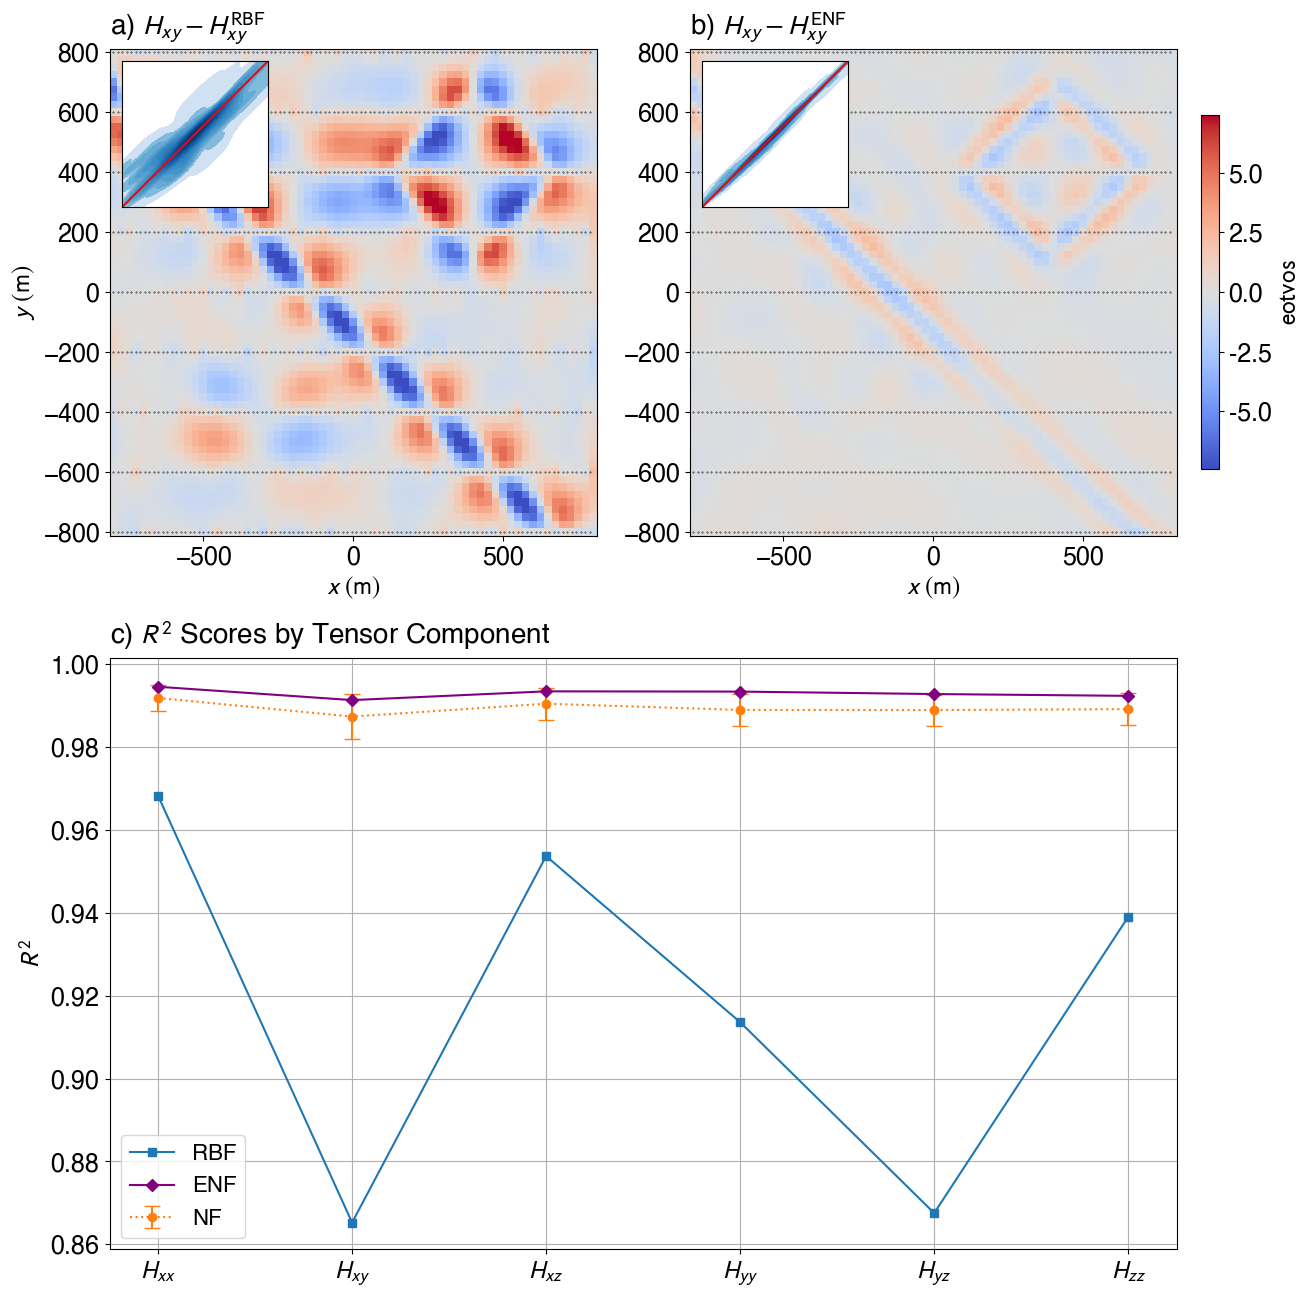

In [11]:
# Plotting the errormaps!
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.filterwarnings("ignore")

fig, ax_ = plt.subplots(2, 2, figsize=(13, 13), layout="constrained")
gs = ax_[1, 0].get_gridspec()
# remove the underlying Axes
for ax in ax_[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, 0:])

k = 1
labels = ["a) ", "b) ", "c) "]
to_plot = [rbf_grid[:, k], enf_grid[:, k]]
titles = [r"$H_{xy} - H^{\mathrm{RBF}}_{xy}$", r"$H_{xy} - H^{\mathrm{ENF}}_{xy}$"]
ll = np.nanpercentile(np.abs(ftg_hr[:, k] - to_plot[0]), 99)

for i in range(3):
    
    if i == 2:
        ax = axbig
        components = [r"$H_{xx}$", r"$H_{xy}$", r"$H_{xz}$", 
              r"$H_{yy}$", r"$H_{yz}$", r"$H_{zz}$"]

        x = range(len(components))
        ax.plot(x, rbf_r2, label="RBF", marker='s')
        ax.errorbar(x, np.mean(nf_r2, axis=0), yerr=np.std(nf_r2, axis=0),
                    label="NF", linestyle="dotted", marker="o", capsize=6)
        ax.plot(x, enf_r2, label="ENF", marker='D', c="purple")
        ax.set_xticks(x, components)
        ax.set_ylabel(r"$R^2$")
        ax.set_title(labels[i] + r"$R^2$ Scores by Tensor Component", loc="left", pad=10)
        ax.legend(fontsize=16)
        ax.grid(True)
    
    else:
        ax = ax_.ravel()[i]
        m = ax.pcolormesh(x_mesh, y_mesh, (ftg_hr[:, k] - to_plot[i]).reshape(shape).T, vmin=-ll, vmax=ll, cmap="coolwarm")
        ax.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c="k", alpha=1)
        ax.set_title(labels[i] + titles[i], loc="left", pad=10)
        ax.set_aspect("equal")
        newaxes = inset_axes(ax, width="30%", height="30%", loc=2)
        sns.kdeplot(x=ftg_hr[:, k], y=to_plot[i], ax=newaxes, fill=True,  thresh=1e-3, levels=20, cmap="Blues", norm=mcolors.LogNorm())
        #newaxes.scatter(ftg_test[:, k], to_plot[i], s=0.2, alpha=0.4)
        newaxes.axline((0, 0), slope=1, c="r")
        newaxes.set_xticks([])
        newaxes.set_yticks([])
        newaxes.set_aspect("equal")
        newaxes.set_xlim([-15, 15])
        newaxes.set_ylim([-15, 15])

        if i == 1:
            cbar = plt.colorbar(mappable=m, orientation="vertical", format="%.1f", shrink=0.6, pad=0.05, label=r"$\mathrm{eotvos}$")
        
        ax.set_xlabel(r"$x\ (\mathrm{m})$")
        if i == 0:
            ax.set_ylabel(r"$y\ (\mathrm{m})$")

plt.savefig("./Figures/synthetic_errormap.png", dpi=350)    
plt.show()

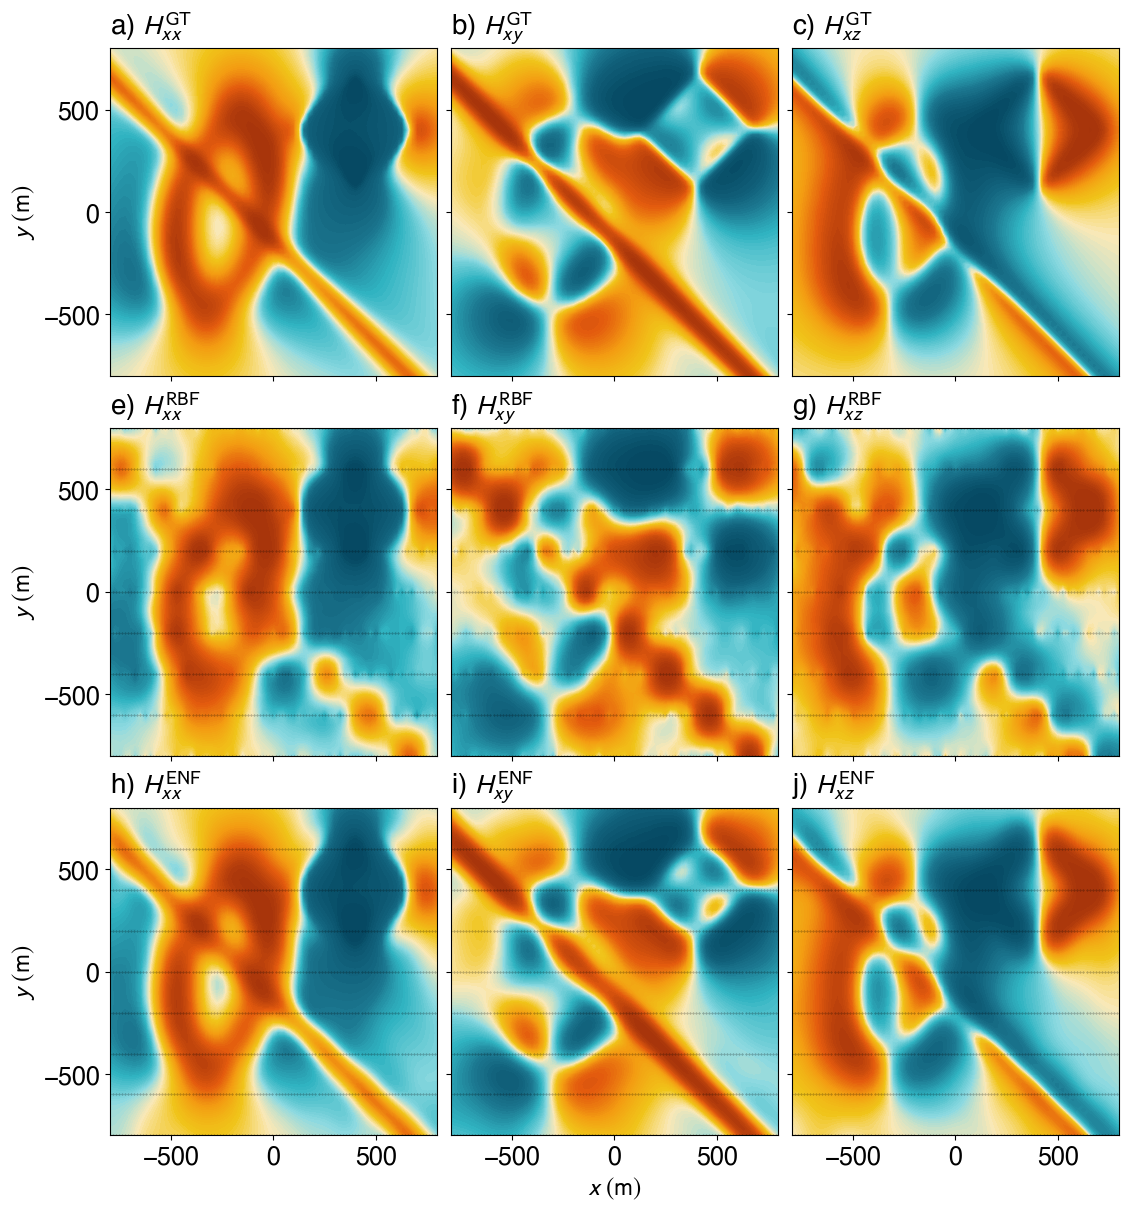

In [15]:
# Plot the NF!
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
enf_labels = [r"$H^{\mathrm{ENF}}_{xx}$", r"$H^{\mathrm{ENF}}_{xy}$", r"$H^{\mathrm{ENF}}_{xz}$",
             r"$H^{\mathrm{ENF}}_{yy}$", r"$H^{\mathrm{ENF}}_{yz}$", r"$H^{\mathrm{ENF}}_{zz}$"]
all_labels = [r"$H^{\mathrm{GT}}_{xx}$", r"$H^{\mathrm{GT}}_{xy}$", r"$H^{\mathrm{GT}}_{xz}$",
              r"$H^{\mathrm{GT}}_{yy}$", r"$H^{\mathrm{GT}}_{yz}$", r"$H^{\mathrm{GT}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
to_plot = [ftg_hr, rbf_grid, enf_grid]
label_list = [all_labels, rbf_labels, enf_labels]
# Colormap capping
cmax = 15

fig, ax = plt.subplots(3, 3, figsize=(12, 12), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) "]

# Contour plots
for i in range(9):
    current_set = to_plot[i // 3]
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(current_set[:, idx[i % 3]].reshape(shape)).T,
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + label_list[i // 3][idx[i % 3]], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[6].set_ylabel(r"$y\ (\mathrm{m})$")
ax[7].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax[3:]]

plt.savefig("./Figures/synthetic_comparison.png", dpi=350, bbox_inches="tight")
plt.show()